## This notebook finds the single visits corresponding to a particular position. Then it gives the MJD for each of them.

In [1]:
# Import python packages
import time
import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
import pandas as pd

%matplotlib inline


In [2]:
# Import tasks from the LSST Science Pipelines for reprocessing images
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

import lsst.sphgeom
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.geom import SpherePoint, Angle

In [3]:
# Import LSST Science Pipelines packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay

import lsst.afw.table as afwTable
import lsst.geom as geom
import lsst.pipe.tasks.fakes as fakes

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
from lsst.afw.display import Mosaic
import matplotlib.pyplot as plt

In [5]:
# For DC2 gen3, these are the only options
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'

butler = Butler(repo, collections=collection)
registry = butler.registry

In [6]:
# Central (RA, Dec) position (in degrees) at which to insert stars:
racen = 59.65688129
deccen = -36.75083078

In [7]:
import lsst.sphgeom

pixelization = lsst.sphgeom.HtmPixelization(12)

In [8]:
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(racen, deccen)
    )
)

# Obtain and print the scale to provide a sense of the size of the sky pixelization being used
scale = pixelization.triangle(htm_id).getBoundingCircle().getOpeningAngle().asDegrees()*3600
print(f'HTM ID={htm_id} at level={pixelization.getLevel()} is a ~{scale:0.2}" triangle.')

HTM ID=147183400 at level=12 is a ~6.7e+01" triangle.


In [9]:
datasetRefs_u = registry.queryDatasets("calexp", htm20=htm_id, band="u")
datasetRefs_g = registry.queryDatasets("calexp", htm20=htm_id, band="g")
datasetRefs_r = registry.queryDatasets("calexp", htm20=htm_id, band="r")
datasetRefs_i = registry.queryDatasets("calexp", htm20=htm_id, band="i")

#print("Found ", datasetRefs_u.count(discard=True), " u-band calexps at that position.")
#print("Found ", datasetRefs_g.count(discard=True), " g-band calexps at that position.")
#print("Found ", datasetRefs_r.count(discard=True), " r-band calexps at that position.")
#print("Found ", datasetRefs_i.count(discard=True), " i-band calexps at that position.")
print("Found ", datasetRefs_u.count(), " u-band calexps at that position.")
print("Found ", datasetRefs_g.count(), " g-band calexps at that position.")
print("Found ", datasetRefs_r.count(), " r-band calexps at that position.")
print("Found ", datasetRefs_i.count(), " i-band calexps at that position.")

Found  40  u-band calexps at that position.
Found  60  g-band calexps at that position.
Found  134  r-band calexps at that position.
Found  130  i-band calexps at that position.


In [10]:
for i, ref in enumerate(datasetRefs_u):
    uref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_g):
    gref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_r):
    rref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_i):
    iref = ref
    if i > 0:
        break

#### Here I am taking the Dataref for u-band and writing the dataId portion to a file. Then I repeat that for g, r and i bands.

In [11]:
fox = open('u_band.out', 'w')

for i, ref in enumerate(datasetRefs_u):
    uref = ref
    fox.write(str(uref.dataId))
    fox.write('\n')
    if i > datasetRefs_u.count():
        break

fox.close()

In [12]:
fox = open('g_band.out', 'w')

for i, ref in enumerate(datasetRefs_g):
    gref = ref
    fox.write(str(gref.dataId))
    fox.write('\n')
    if i > datasetRefs_g.count():
        break

fox.close()

In [13]:
fox = open('r_band.out', 'w')

for i, ref in enumerate(datasetRefs_r):
    rref = ref
    fox.write(str(rref.dataId))
    fox.write('\n')
    if i > datasetRefs_r.count():
        break

fox.close()

In [14]:
fox = open('i_band.out', 'w')

for i, ref in enumerate(datasetRefs_i):
    iref = ref
    fox.write(str(iref.dataId))
    fox.write('\n')
    if i > datasetRefs_i.count():
        break

fox.close()

##### Now I read in that data and then place it in the format for the dataId to be read into butler

At the end here I produce a dataframe for each filter with the visit and detector number.

In [15]:
df_u = pd.read_csv('u_band.out', header=None)
print(df_u)
#df2 = pd.DataFrame.from_dict(df)
df_u['visit'] = df_u[2].str.split(':', expand=True)[1]
df_u['detector'] = df_u[1].str.split(':', expand=True)[1]
detector_u = df_u['detector']
visit_u = df_u['visit']

df_g = pd.read_csv('g_band.out', header=None)
#df2 = pd.DataFrame.from_dict(df)
df_g['visit'] = df_g[2].str.split(':', expand=True)[1]
df_g['detector'] = df_g[1].str.split(':', expand=True)[1]
detector_g = df_g['detector']
visit_g = df_g['visit']

df_r = pd.read_csv('r_band.out', header=None)
#df2 = pd.DataFrame.from_dict(df)
df_r['visit'] = df_r[2].str.split(':', expand=True)[1]
df_r['detector'] = df_r[1].str.split(':', expand=True)[1]
detector_r = df_r['detector']
visit_r = df_r['visit']

df_i = pd.read_csv('i_band.out', header=None)
#df2 = pd.DataFrame.from_dict(df)
df_i['visit'] = df_i[2].str.split(':', expand=True)[1]
df_i['detector'] = df_i[1].str.split(':', expand=True)[1]
detector_i = df_i['detector']
visit_i = df_i['visit']

                               0               1                2      3
0   {instrument: 'LSSTCam-imSim'     detector: 6    visit: 911700   ...}
1   {instrument: 'LSSTCam-imSim'     detector: 8    visit: 418204   ...}
2   {instrument: 'LSSTCam-imSim'     detector: 8    visit: 700215   ...}
3   {instrument: 'LSSTCam-imSim'    detector: 13    visit: 949602   ...}
4   {instrument: 'LSSTCam-imSim'    detector: 21    visit: 911699   ...}
5   {instrument: 'LSSTCam-imSim'    detector: 28    visit: 740371   ...}
6   {instrument: 'LSSTCam-imSim'    detector: 31    visit: 660271   ...}
7   {instrument: 'LSSTCam-imSim'    detector: 39    visit: 466757   ...}
8   {instrument: 'LSSTCam-imSim'    detector: 46   visit: 1222589   ...}
9   {instrument: 'LSSTCam-imSim'    detector: 49   visit: 1187398   ...}
10  {instrument: 'LSSTCam-imSim'    detector: 58    visit: 277061   ...}
11  {instrument: 'LSSTCam-imSim'    detector: 61    visit: 277061   ...}
12  {instrument: 'LSSTCam-imSim'    detector: 67   

#### Now we use the dataframes from above to go to the Butler to get MJD for each observation.

In [16]:
MJD_u = []
MJD_g = []
MJD_r = []
visit_rr = []
detector_rr = []
MJD_i = []

#for i in range(0,len(df_u)):
#    dataId = {'visit': int(visit_u[i]), 'detector': int(detector_u[i]), 'band': 'u'}
#    calexp = butler.get('calexp', **dataId)
#    a = calexp.getInfo().getVisitInfo().getDate().get(lsst.daf.base.DateTime.MJD)
#    MJD_u.append(a)
    
#for i in range(0,len(df_g)):
#    dataId = {'visit': int(visit_g[i]), 'detector': int(detector_g[i]), 'band': 'g'}
#    calexp = butler.get('calexp', **dataId)
#    a = calexp.getInfo().getVisitInfo().getDate().get(lsst.daf.base.DateTime.MJD)
#    MJD_g.append(a)

for i in range(0,len(df_r)):
    dataId = {'visit': int(visit_r[i]), 'detector': int(detector_r[i]), 'band': 'r'}
    calexp = butler.get('calexp', **dataId)
    a = calexp.getInfo().getVisitInfo().getDate().get(lsst.daf.base.DateTime.MJD)
    MJD_r.append(a)
    visit_rr.append(visit_r[i])
    detector_rr.append(detector_r[i])
    
#for i in range(0,len(df_i)):
#    dataId = {'visit': int(visit_i[i]), 'detector': int(detector_i[i]), 'band': 'i'}
#    calexp = butler.get('calexp', **dataId)
#    a = calexp.getInfo().getVisitInfo().getDate().get(lsst.daf.base.DateTime.MJD)
#    MJD_i.append(a)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/obs_base/g7bd0041fb8+3c51939e74/python/lsst/obs/base/formatters/fitsExposure.py:639: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 1, visit: 1155523} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/obs_base/g7bd0041fb8+3c51939e74/python/lsst/obs/base/formatters/fitsExposure.py:639: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 4, visit: 1230596} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/obs_base/g7bd0041fb8+3c51939e74/python/lsst/obs/bas

In [17]:
df1 = pd.DataFrame(visit_rr)
df2 = pd.DataFrame(detector_rr)
df3 = pd.DataFrame(MJD_r)

data = pd.DataFrame({'visit': visit_rr, 'detector': detector_rr, 'MJD': MJD_r}, columns=['visit','detector','MJD'])

r_band = data.loc[data['MJD'] < 61329.2]
r_band2 = r_band.loc[r_band['MJD'] > 61316.0]
print(r_band2)

#print(df3)
#result = pd.concat(frames)
#print(result)

        visit detector           MJD
10    1190718       17  61325.177183
24    1192173       36  61327.198789
47    1186064       69  61319.366707
51    1193692       74  61329.139063
59    1193692       81  61329.139063
60    1193728       81  61329.155732
62    1185205       82  61318.355588
71    1192140       95  61327.183104
72    1193025       99  61328.211337
76    1189463      104  61323.365175
100   1192990      139  61328.194828
127   1190764      175  61325.198639


In [19]:
udf = pd.DataFrame(MJD_u)
gdf = pd.DataFrame(MJD_g)
rdf = pd.DataFrame(MJD_r)
idf = pd.DataFrame(MJD_i)

udf.to_csv('output/udf.csv')
gdf.to_csv('output/gdf.csv')
rdf.to_csv('output/rdf.csv')
idf.to_csv('output/idf.csv')

In [8]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

In [40]:
#fig, ax = plt.subplots(figsize=(20,20))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dataId1 = {'visit': 1185205, 'detector': 5, 'band': 'r'}
    dataId2 = {'visit': 1185205, 'detector': 6, 'band': 'r'}
    dataId3 = {'visit': 1185205, 'detector': 7, 'band': 'r'}
    dataId4 = {'visit': 1185205, 'detector': 8, 'band': 'r'}
    dataId5 = {'visit': 1185205, 'detector': 12, 'band': 'r'}
    im1 = butler.get('calexp', **dataId1)
    im2 = butler.get('calexp', **dataId2)
    im3 = butler.get('calexp', **dataId3)
    im4 = butler.get('calexp', **dataId4)
    im5 = butler.get('calexp', **dataId5)
#display = afwDisplay.Display(frame=fig)
#display.scale('asinh', 'zscale')
#display.mtv(im1.image)

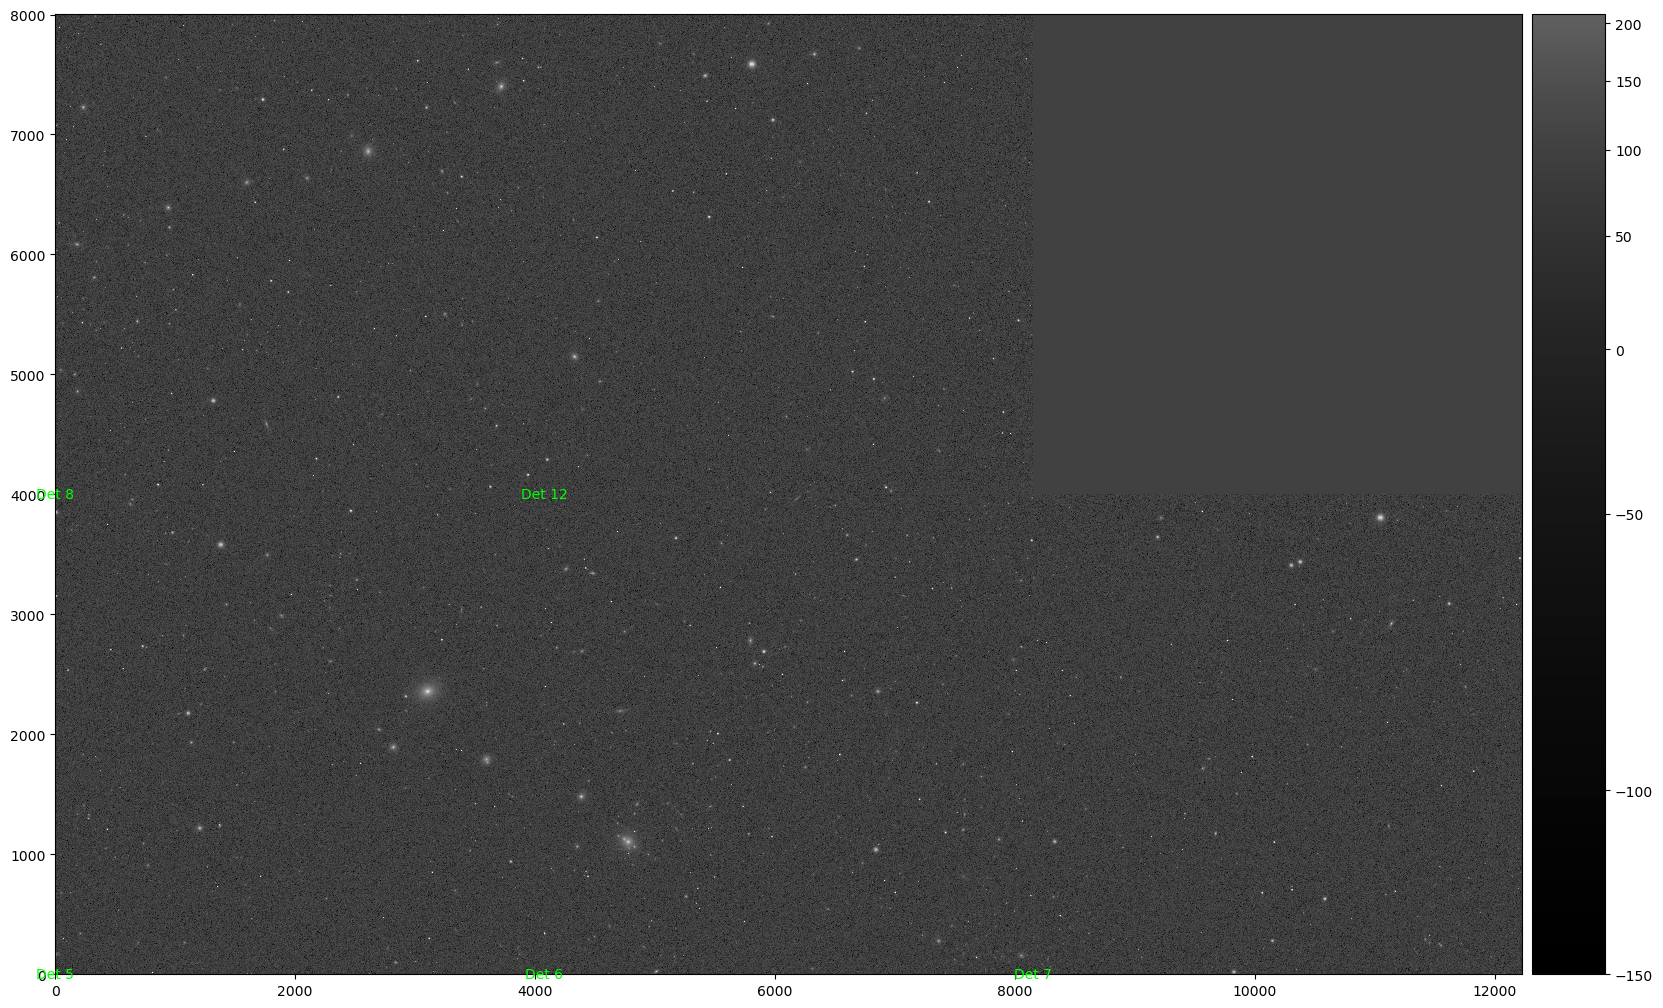

In [45]:
fig = plt.figure(figsize=(20,20))
m = Mosaic()
m.setGutter(5)
m.setBackground(10)
m.setMode("square")  

images = [im1.image, im2.image, im3.image, im4.image, im5.image]
labels = ["Det 5", "Det 6", "Det 7","Det 8", "Det 12"]

mosaic = m.makeMosaic(images)
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(mosaic)
m.drawLabels(labels, display)